# Estimation of the mass and infall rate within filaments




## Preparation of integrated images (in the same velocity range)

In [1]:
import numpy as np
from spectral_cube import SpectralCube
from astropy.io import fits
from reproject import reproject_exact
import matplotlib.pyplot as plt
import aplpy
import sys
sys.path.append('../')
from B5setup import *
import os
import astropy.units as u
from astropy.modeling.models import Gaussian2D
from photutils.psf import create_matching_kernel
from scipy import stats
from astropy.table import Table
from regions import Regions
from astropy.wcs import WCS
from scipy.integrate import simpson

%matplotlib inline

In [2]:
# we need to make sure the images are both at the same resolution and the same pixel scale, as well as integrated in the same range
# to make everything easier, both are in K
hc3n_10_9_original = 'B5-NOEMA+30m-H3CN-10-9_cut_K'
hc3n_8_7_original = 'B5-NOEMA+30m-H3CN-8-7_cut_K'
hc3n_10_9_snr = hc3n_10_9_original +'_snr'
hc3n_10_9_rms = hc3n_10_9_original +'_rms'
hc3n_10_9_Tpeak = hc3n_10_9_original +'_Tpeak'
hc3n_10_9_snr_regrid = hc3n_10_9_snr + '_regrid'
hc3n_10_9_rms_regrid = hc3n_10_9_rms + '_regrid'
hc3n_10_9_Tpeak_regrid = hc3n_10_9_Tpeak  + '_regrid'

hc3n_8_7_snr = hc3n_8_7_original + '_snr'
hc3n_8_7_rms = hc3n_8_7_original + '_rms'
hc3n_8_7_Tpeak = hc3n_8_7_original + '_Tpeak'

velinit = 9.2
velend = 11.2 
velinitrms = 5.1

hc3n_10_9_int = hc3n_10_9_original+'_int_' + str(velinit) + '_' + str(velend)
hc3n_8_7_int = hc3n_8_7_original+'_int_' + str(velinit) + '_' + str(velend)

# the beam of the 8-7 transition is larger 
hc3n_10_9_int_convolved = hc3n_10_9_int + '_convolved'
hc3n_10_9_int_convolved_regrid = hc3n_10_9_int_convolved + '_regrid'

hc3n_ratio = hc3n_10_9_int_convolved_regrid + '_over_8_7'
hc3n_ratio_kde = hc3n_ratio + '_kde'
region_filaments = 'filaments_mass_area.reg'
hc3n_Ntot = hc3n_10_9_int + '_Ntot'


In [3]:
if not os.path.exists(hc3n_10_9_int+'.fits'):
    cube109 = SpectralCube.read(hc3n_10_9_original+'.fits')
    subcube = cube109.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)
    mom0 = subcube.moment0()
    mom0.write(hc3n_10_9_int+'.fits')

if not os.path.exists(hc3n_8_7_int+'.fits'):
    cube87 = SpectralCube.read(hc3n_8_7_original+'.fits')
    subcube2 = cube87.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)
    mom02 = subcube2.moment0()
    mom02.write(hc3n_8_7_int+'.fits')
    

In [4]:
if not os.path.exists(hc3n_10_9_int_convolved+'.fits'):
    # we need to calculate the covariance of the gaussian of the objective and initial resolutions
    pixel_factor = np.abs(mom0109_head['CDELT2']) # how many degrees in a pixel, on the image we will convolve
    sigma_maj_obj = mom087_head['BMAJ'] # degrees
    sigma_min_obj = mom087_head['BMIN'] # degrees
    pa_obj = mom087_head['BPA']# degrees

    raise IOError('Convolve to Major='+str(np.round(sigma_maj_obj*3600, 3))+'arcsec, minor='+
          str(np.round(sigma_min_obj*3600, 3))+'arcsec, PA='+str(np.round(pa_obj, 3))+'deg')
else:
    print('File exists, continue')

File exists, continue


In [5]:
if not os.path.exists(hc3n_10_9_int_convolved_regrid+'.fits'):
    hdu109 = fits.open(hc3n_10_9_int_convolved+'.fits')
    header87 = fits.getheader(hc3n_8_7_int+'.fits')
    new_array109, footprint = reproject_exact(hdu109[0], header87)
    new_head = hdu109[0].header
    hdu109.close()
    tags = ['CRPIX1', 'CRPIX2', 'CDELT1', 'CDELT2', 'CUNIT1', 'CUNIT2', 'CTYPE1', 'CTYPE2', 
            'CRVAL1', 'CRVAL2', 'NAXIS1', 'NAXIS2', 'ALTRVAL', 'ALTRPIX']
    for tag in tags:
        new_head[tag] = header87[tag]
    fits.writeto(hc3n_10_9_int_convolved_regrid+'.fits', new_array109, new_head)
    
else:
    print('All files are ready.')

All files are ready.


## Line ratio across the map

We define the line ratio as

\begin{equation}
R = \frac{ \int T_{R,10-9}dv }{\int T_{R,8-7}dv}
\end{equation}



In [6]:
# first we need where the emission of both molecules has significant SNR

if not os.path.exists(hc3n_8_7_snr+'.fits'):
    cube87 = SpectralCube.read(hc3n_8_7_original+'.fits')
    rmsmap = np.nanstd(cube87.spectral_slab(velinitrms*u.km/u.s, velinit*u.km/u.s).unmasked_data[:,:,:].value, axis=0)
    Tpeakmap = np.nanmax(cube87.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s).unmasked_data[:,:,:].value, axis=0)
    snrmap87 = Tpeakmap / rmsmap
    
    hdcube=cube87.header.copy()
    key_remove=['NAXIS3','CRPIX3','CDELT3','CUNIT3','CTYPE3','CRVAL3','SPECSYS']
    for key_i in key_remove:
        hdcube.remove(key_i)
    hdcube['WCSAXES'] = 2
    hdcube['NAXIS'] = 2
    fits.writeto(hc3n_8_7_rms+'.fits', rmsmap, hdcube)
    print('Created RMS file')
    fits.writeto(hc3n_8_7_Tpeak+'.fits', Tpeakmap, hdcube)
    print('Created Tpeak file')
    hdcubesnr = hdcube.copy()
    hdcubesnr['BUNIT'] = ''
    fits.writeto(hc3n_8_7_snr+'.fits', snrmap87, hdcubesnr)
    print('Created SNR file')
else:
    snrmap87 = fits.getdata(hc3n_8_7_snr+'.fits')
    
if not os.path.exists(hc3n_10_9_snr+'.fits'):
    cube109= SpectralCube.read(hc3n_10_9_original+'.fits')
    rmsmap = np.nanstd(cube109.spectral_slab(velinitrms*u.km/u.s, velinit*u.km/u.s).unmasked_data[:,:,:].value, axis=0)
    Tpeakmap = np.nanmax(cube109.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s).unmasked_data[:,:,:].value, axis=0)
    snrmap = Tpeakmap / rmsmap
    
    hdcube=cube109.header.copy()
    key_remove=['NAXIS3','CRPIX3','CDELT3','CUNIT3','CTYPE3','CRVAL3','SPECSYS']
    for key_i in key_remove:
        hdcube.remove(key_i)
    hdcube['WCSAXES'] = 2
    hdcube['NAXIS'] = 2
    fits.writeto(hc3n_10_9_rms+'.fits', rmsmap, hdcube)
    print('Created RMS file')
    fits.writeto(hc3n_10_9_Tpeak+'.fits', Tpeakmap, hdcube)
    print('Created Tpeak file')
    hdcubesnr = hdcube.copy()
    hdcubesnr['BUNIT'] = ''
    fits.writeto(hc3n_10_9_snr+'.fits', snrmap, hdcubesnr)
    print('Created SNR file')

    

In [7]:
# to regrid while keeping flux, we need to regrid both the rms and the Tpeak and then do the snrratio
if not os.path.exists(hc3n_10_9_snr_regrid+'.fits'):
    rmsmap = fits.open(hc3n_10_9_rms+'.fits')
    rmshead = fits.getheader(hc3n_8_7_rms+'.fits')
    newrmsmap, footprint = reproject_exact(rmsmap[0], rmshead)
    rmsmap.close()
    fits.writeto(hc3n_10_9_rms_regrid+'.fits', newrmsmap, rmshead, overwrite=True)
    
    Tpeakmap = fits.open(hc3n_10_9_Tpeak+'.fits')
    Tpeakhead = fits.getheader(hc3n_8_7_Tpeak+'.fits')
    newTpeakmap, footprint = reproject_exact(Tpeakmap[0], Tpeakhead)
    Tpeakmap.close()
    fits.writeto(hc3n_10_9_Tpeak_regrid+'.fits', newTpeakmap, Tpeakhead, overwrite=True)
    
    snrmap109 = newTpeakmap / newrmsmap
    fits.writeto(hc3n_10_9_snr_regrid+'.fits', snrmap_regrid, fits.getheader(hc3n_8_7_snr+'.fits'))
    
else:
    snrmap109 = fits.getdata(hc3n_10_9_snr_regrid+'.fits')


In [8]:
if not os.path.exists(hc3n_ratio+'.fits'):
    maskmap = (snrmap109 > 5) * (snrmap87 > 5)
    hc3n109 = fits.getdata(hc3n_10_9_int_convolved_regrid+'.fits')
    hc3n109masked = np.where(maskmap, hc3n109, np.nan)
    hc3n87 = fits.getdata(hc3n_8_7_int+'.fits')
    hc3n87masked = np.where(maskmap, hc3n87, np.nan)

    ratio = hc3n109masked/hc3n87masked
    newhead_ratio = fits.getheader(hc3n_8_7_int+'.fits')
    newhead_ratio['BUNIT'] = ' '
    fits.writeto(hc3n_ratio+'.fits', ratio, newhead_ratio)

else:
    ratio = fits.getdata(hc3n_ratio+'.fits')

header10 = fits.getheader(hc3n_10_9_original+'.fits')
header8 = fits.getheader(hc3n_8_7_original+'.fits')

ratio_flat = ratio.flatten()
ratio_flat = ratio_flat[~np.isnan(ratio_flat)]
mean = np.mean(ratio_flat)
stddev = np.std(ratio_flat)
Abeam = np.pi * header8['BMAJ'] * header8['BMIN'] / 4
Apix = np.abs(header8['CDELT1'] * header8['CDELT2'])
Ntot = len(ratio_flat)
mean_unc = stddev / np.sqrt(Ntot * Apix/Abeam)
print('The mean of the ratio is '+str(np.round(mean, 2))+' with a standard deviation of '+str(np.round(stddev, 2)))
print('<R> = '+str(np.round(mean, 2))+' +- '+str(np.round(mean_unc, 2)))



The mean of the ratio is 0.56 with a standard deviation of 0.38
<R> = 0.56 +- 0.01


/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)


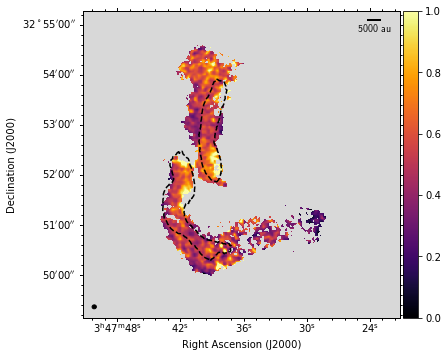

In [9]:
# this is just to have a visual of the value
fig = plt.figure(figsize=(6,6))
gc = plot_aplpy_subfig(hc3n_ratio+'.fits', fig, (1,1,1), 'linear', 0, 1, 'inferno')
nh3mom0file = '../B5_previous_data/B5_VLA_GBT_model_11_mom0_reproject.fits'
nh3mom0levels = [0.1]
gc.show_contour(nh3mom0file, colors='k', linestyles='dashed', levels=nh3mom0levels, zorder=34)

Text(1.04, 2, '0.54$_{-0.16}^{+0.16}$')

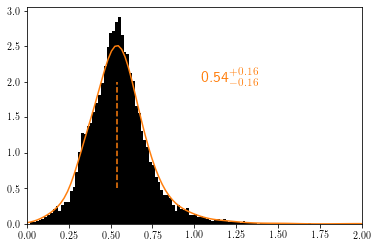

In [10]:
# to make sure it distributes mostly random, we do a KDE
data = fits.getdata(hc3n_ratio+'.fits').flatten()
data = data[~np.isnan(data)]
if not os.path.exists(hc3n_ratio_kde + '.npy'):
    data_kde = np.linspace(0, 2, 100)
    p_range = np.array([0.15865 * 100, 50., 0.84135 * 100]) # one sigma
    ratio_median_unc = np.round(np.percentile(data, p_range), decimals=2)

    kernel = stats.gaussian_kde(data)
    dens = kernel(data_kde)
    dens /= simpson(dens, data_kde) # normalizing of probability

    datasave = np.array([data_kde, dens, ratio_median_unc], dtype=object)

    np.save(hc3n_ratio_kde + '.npy', datasave)
else:
    datasave = np.load(hc3n_ratio_kde + '.npy', allow_pickle=True)
    data_kde, dens, ratio_median_unc = datasave

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data, fc='k', bins='fd', density=True)
ax.plot(data_kde, dens)
ax.set_xlim([0, 2])
ax.plot([ratio_median_unc[1], ratio_median_unc[1]], [0.5, 2], color='C1', ls='--')
ax.text(ratio_median_unc[1]+0.5,2,r'{0}$_{{{1:.2f}}}^{{+{2:.2f}}}$'.format(ratio_median_unc[1], ratio_median_unc[0]-ratio_median_unc[1], ratio_median_unc[2]-ratio_median_unc[1]), size=16, color='C1')


## Deriving the density and column density

The variations on the ratio seem not to be systematic, except maybe at the location of condensation 1 (there is something going on in there... discuss). So we decide to move on and estimate the masses of the filaments.

From Rosolowsky et al 2008, Barnard 5 (pointings 189 to 192) has the following sampled T$_k$:
- T(189) = $10.10 \pm 0.4$ K (north)
- T(190) = $10.10 \pm 0.4$ K (north)
- T(191) = $10.00 \pm 0.4$ K (north)
- T(192) = $11.70 \pm 0.3$ K (south, B5-IRS1 position)

With a few tests in RADEX online, we see that with the same parameters as Pineda+2020 we can get a good agreement with both T$_R$ (1.2 K for 10-9 and 2.28 K for 8-7) and the ratio (10-9/8-7 is approx 0.55) for n=10$^5$ cm$^{-3}$. Therefore, we use his table to estimate the column density.


In [11]:
# function and table are taken from NOEMA_streamer_analysis repo (Pineda+2020)
from astropy.constants import c, h, k_B, G
gaussmaskfile = 'gaussfit/' + hc3n_10_9_original +'_mask.fits'
header_ratio = fits.getheader(hc3n_ratio+'.fits')
def col_dens_hc3n(file_tdv, nup=10):
    """
    converts integrated intensity file into column density of the upper level for HC3N
    :param file_tdv: FITS file with integrated intensity file in K km/s
    :param nup: integer (default = 10)
    :return: Column density in units of cm^-2, as Quantity array
    """
    if nup == 8:
        nu = 72.78382*u.GHz
        A_ij = 0.294E-04/u.s
    elif nup == 10:
        nu = 90.97902*u.GHz
        A_ij = 0.581e-4/u.s # from CDMS 
    else:
        print('This transition is not available yet')
        return np.nan
    data, hd = fits.getdata(file_tdv, header=True)
    # freq = hd['RESTFREQ'] * u.Hz
    TdV = data * u. K * u.km / u.s
    N_col = ((8 * np.pi * k_B * nu ** 2) / (h * c ** 3 * A_ij) * TdV ).to(1 / u.cm ** 2)
    return N_col

# function and table are taken from NOEMA_streamer_analysis repo (Pineda+2020)
t13 = Table.read('N13.0_8-7_10-9.dat', format='ascii')
n_N13 = 10**(t13['log10(dens)'])
T_N13 = t13['Tkin']
r_N13 = 1./t13['ratio']


def plot_ratios(ax, dens, ratio, temp, N_col=13, label_i=r'N(HC$_3$N)=10$^{12}$ cm$^{-2}$', file_out='test.pdf'):
    """
    """
    ax.scatter(dens[temp == 10.], ratio[temp == 10.], c='#377eb8', alpha=0.7, label=r'T$_{\rm kin}$=10 K')
    ax.scatter(dens[temp == 12.25], ratio[temp == 12.25], c='#e41a1c', alpha=0.7, label=r'T$_{\rm kin}$=12.25 K')
    dens_min = 500
    dens_max = 3e6
    ax.set_xlim(dens_min, dens_max)
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
    ax.set_xlabel(r'H$_2$ Density (cm$^{-3}$)')
    ax.set_ylabel(r'Ratio of HC$_3$N (10-9)/(8-7)')
    ax.text(1e3, 0.85, label_i, fontsize=12)
    ax.text(1e3, 0.775, r'$\Delta$v=0.5 km s$^{-1}$', fontsize=12)
    ax.legend(frameon=False, loc=4)
    return


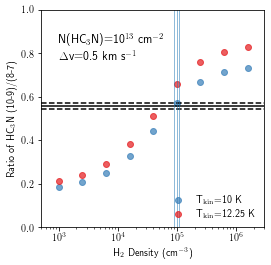

In [12]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
plot_ratios(ax, n_N13, r_N13, T_N13, N_col=13, label_i=r'N(HC$_3$N)=10$^{13}$ cm$^{-2}$')
ax.axhline(mean, color='k')
ax.axhline(mean-mean_unc, linestyle="--", color='k')
ax.axhline(mean+mean_unc, linestyle="--", color='k')
ax.axvline(1.1e5, linewidth=0.5)
ax.axvline(1e5, linewidth=0.5)
ax.axvline(0.9e5, linewidth=0.5)
fig.savefig('N13.0_8-7_10-9_with_B5_ratio.pdf', bbox_inches='tight')

From the plot we can estimate the average H2 density $n=(1.0\pm0.1)\times10^5$ cm$^{-3}$ (using a manual zoom and guided by the T=10 K dots). With this, we can obtain the $T_{ex}$ of the 10-9 line from RADEX, $T_{ex}=6.36$ K.

In [13]:
T = 10 * u.K
T_ex = 6.36 * u.K # of 10-9 transition of HC3N
B0 = 4549.0579 * u.MHz #  (Creswell, Winnewisser & Gerry 1977) 
gu = 21 #2 J_u + 1, for J=10
Eu = 24.01482 * u.K
Qrot = k_B * T / (h * B0) * np.exp( (h * B0) / (3 * k_B * T))

if not os.path.exists(hc3n_Ntot+'.fits'):
    maskmap = fits.getdata(gaussmaskfile)
    Ncol10 = col_dens_hc3n(hc3n_10_9_int+'.fits')
    
    factor_Ntot = Qrot/gu * np.exp((Eu / T_ex).value)

    colhead = fits.getheader(hc3n_10_9_int_convolved+'.fits')
    colhead['BUNIT'] = 'cm-2'
    Ntot = (Ncol10 * factor_Ntot).to(1/u.cm**2)
    Ntot = np.where(maskmap, Ntot, np.nan)

    fits.writeto(hc3n_Ntot+'.fits', Ntot.value, colhead)
else:
    Ntot, colhead = fits.getdata(hc3n_Ntot+'.fits', header=True)
    Ntot = Ntot / u.cm**2
    

indexes_zero = Ntot>0 * ~np.isnan(Ntot)
Ntot_flat = Ntot[indexes_zero].flatten()
mean_Ntot = np.mean(Ntot_flat)
Abeam10 = np.pi * colhead['BMAJ'] * colhead['BMIN'] / 4
Apix10 = np.abs(colhead['CDELT1']*colhead['CDELT2'])
stddev_Ntot = np.std(Ntot_flat)
Nind = len(Ntot_flat) * Apix10/Abeam10
mean_Ntot_unc = stddev_Ntot / np.sqrt(Nind)
print('The mean column density is '+str(np.round(mean_Ntot/1e13, 3)) + r' x10$^{13}$ and the standard deviation is '+str(np.round(stddev_Ntot/1e13, 3)) + r' x10$^{13}$')
print('<N> = '+str(np.round(mean_Ntot/1e13, 3)) + ' +- '+str(np.round(mean_Ntot_unc/1e13, 3))+ ' (x10^13)')

The mean column density is 1.509 1 / cm2 x10$^{13}$ and the standard deviation is 0.802 1 / cm2 x10$^{13}$
<N> = 1.509 1 / cm2 +- 0.028 1 / cm2 (x10^13)


In [14]:
from astropy.constants import u as amu
mu_mass = 2.73 # counting H and He
X_HC3N_min = 3e-10
X_HC3N_max = 2.8e-9

Apix_cm = ((Apix * u.deg**2).to(u.rad**2) * dist_B5**2).to(u.cm**2, equivalencies=u.dimensionless_angles())
M_tot_min = (np.sum(Ntot_flat) * Apix_cm * mu_mass * amu).to(u.Msun) / X_HC3N_max
M_tot_max = (np.sum(Ntot_flat) * Apix_cm * mu_mass * amu).to(u.Msun) / X_HC3N_min

print('The mass that comes from the core is between '+str(M_tot_min)+' and '+str(M_tot_max))

The mass that comes from the core is between 5.915513687682569 solMass and 55.21146108503731 solMass


## Deriving column density and mass for the individual filaments

We can actually take the mean of each filament to compare with Schmiedeke+21

The regions we take for the filaments are including areas where I think emission is falling toward the filament, this does not include all of emission from HC$_3$N.

In [15]:
regions = Regions.read(region_filaments)
fil1 = regions[0].to_pixel(WCS(header_ratio)) # north
fil2 = regions[1].to_pixel(WCS(header_ratio)) # south
fil1_mask = fil1.to_mask().to_image(np.shape(ratio))
fil2_mask = fil2.to_mask().to_image(np.shape(ratio))

        Use another way of creating angles instead (e.g. a less ambiguous string like '-0h1m2.3s' instead. [astropy.coordinates.angles]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


The mean of the ratio is 0.57 with a standard deviation of 0.19
<R> = 0.57 +- 0.013


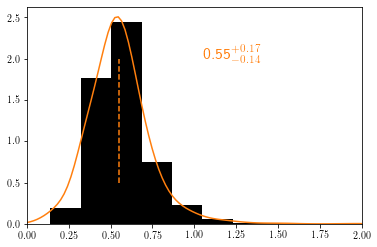

In [16]:
data_fil1 = np.where(fil1_mask, ratio, np.nan).flatten()
data_fil1 = data_fil1[~np.isnan(data_fil1)]
if not os.path.exists(hc3n_ratio_kde + '_fil1.npy'):
    data_kde_fil1 = np.linspace(0, 2, 100)
    p_range_fil1 = np.array([0.15865 * 100, 50., 0.84135 * 100]) # one sigma
    ratio_fil1_median_unc = np.round(np.percentile(data_fil1, p_range_fil1), decimals=2)

    kernel_1 = stats.gaussian_kde(data_fil1)
    dens_1 = kernel_1(data_kde_fil1)
    dens_1 /= simpson(dens_1, data_kde_fil1) # normalizing of probability

    datasave = np.array([data_kde_fil1, dens_1, ratio_fil1_median_unc], dtype=object)

    np.save(hc3n_ratio_kde + '_fil1.npy', datasave)
else:
    datasave = np.load(hc3n_ratio_kde + '_fil1.npy', allow_pickle=True)
    data_kde_fil1, dens_1, ratio_fil1_median_unc = datasave

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data_fil1, fc='k', bins='sturges', density=True)
ax.plot(data_kde_fil1, dens)
ax.set_xlim([0, 2])
ax.plot([ratio_fil1_median_unc[1], ratio_fil1_median_unc[1]], [0.5, 2], color='C1', ls='--')
ax.text(ratio_fil1_median_unc[1]+0.5,2,
        r'{0}$_{{{1:.2f}}}^{{+{2:.2f}}}$'.format(ratio_fil1_median_unc[1], 
                                                 ratio_fil1_median_unc[0]-ratio_fil1_median_unc[1], 
                                                 ratio_fil1_median_unc[2]-ratio_fil1_median_unc[1]), 
        size=16, color='C1')

mean_fil1 = np.mean(data_fil1)
stddev_fil1 = np.std(data_fil1)
Ntot_fil1 = len(data_fil1)
mean_unc_fil1 = stddev_fil1 / np.sqrt(Ntot_fil1 * Apix/Abeam)
print('The mean of the ratio is '+str(np.round(mean_fil1, 2))+' with a standard deviation of '+str(np.round(stddev_fil1, 2)))
print('<R> = '+str(np.round(mean_fil1, 2))+' +- '+str(np.round(mean_unc_fil1, 3)))

In [17]:

fil1_mask10 = fil1.to_mask().to_image(np.shape(Ntot)) # Remember the shape of the ratio map is different from the 10-9 map
Ntot_fil1 = np.where(fil1_mask10, Ntot, np.nan).flatten()
Ntot_fil1 = Ntot_fil1[~np.isnan(Ntot_fil1)]
Apix_cm = ((Apix * u.deg**2).to(u.rad**2) * dist_B5**2).to(u.cm**2, equivalencies=u.dimensionless_angles())
M_tot_fil1_min = (np.sum(Ntot_fil1) * Apix_cm * mu_mass * amu).to(u.Msun) / X_HC3N_max
M_tot_fil1_max = (np.sum(Ntot_fil1) * Apix_cm * mu_mass * amu).to(u.Msun) / X_HC3N_min

print('The mass of Fil-1 is between '+str(M_tot_fil1_min)+' and '+str(M_tot_fil1_max))

The mass of Fil-1 is between 1.1605356409394683 solMass and 10.831665982101704 solMass


In [18]:
fil2_mask10 = fil2.to_mask().to_image(np.shape(Ntot))
Ntot_fil2 = np.where(fil2_mask10, Ntot, np.nan).flatten()
Ntot_fil2 = Ntot_fil2[~np.isnan(Ntot_fil2)]
M_tot_fil2_min = (np.sum(Ntot_fil2) * Apix_cm * mu_mass * amu).to(u.Msun) / X_HC3N_max
M_tot_fil2_max = (np.sum(Ntot_fil2) * Apix_cm * mu_mass * amu).to(u.Msun) / X_HC3N_min

print('The mass of Fil-2 is between '+str(M_tot_fil2_min)+' and '+str(M_tot_fil2_max))

The mass of Fil-2 is between 1.2244250205488945 solMass and 11.427966858456347 solMass


## Mass infall rate in Filament 1

We see a gradient in the perpendicular direction of the filament, from about 10 to 10.3 km/s. We can use this difference to estimate an infall velocity:
\begin{equation}
v_{inf} = \frac{<v_{red}-v_{blue}>}{2}
\end{equation}

Then, the infall rate can be estimated with
\begin{equation}
\dot{m} = S \rho v_{inf}
\end{equation}

We use $\rho = n\times m_{h2}$. S is the area of the surface of the filament, we can use the same approx. as in Spandan's paper, to be consistent in the comparison


In [23]:
S_pc = np.pi * (0.05*u.pc) * 0.2*u.pc
vinf = 0.2 * u.km/u.s
rho = 1e5 * u.cm**-3 * mu_mass * amu


Mdot_fil1 = (S_pc * vinf * rho).to(u.Msun/u.yr)
print(Mdot_fil1)

4.304183318916538e-05 solMass / yr


## Estimate of the conversion factor between cyanoacetyline and hydrogen

The range of values of the mass is one order of magnitude, only because the conversion factor [HC3N/H2] is not fully constrained. We can estimate a conversion factor using the found $n_{H2}$ from RADEX using

\begin{equation}
X = \Big[\frac{HC_3N}{H_2}\Big] = \frac{N(HC_3N)}{n_{H_2}w}
\end{equation}
where $w$ is a characteristic depth. We use 37 arcsec (about 11000 au).

In [20]:
# look for other abundances
w = (37 * dist_B5.value)*u.au # mean width along the filament
radius_mean = w/2
n_H2 = 1.0e5 / u.cm**3
X_fil1 = (mean_Ntot / (n_H2 * w)).decompose()
X_fil1_unc = (mean_Ntot_unc / (n_H2 * w)).decompose()

In [21]:
X_fil1, X_fil1_unc

(<Quantity 9.02718138e-10>, <Quantity 1.69799423e-11>)

In [22]:
M_tot_X = (np.sum(Ntot_flat) * Apix_cm * mu_mass * amu).to(u.Msun) / X_fil1
M_fil1_X = (np.sum(Ntot_fil1) * Apix_cm * mu_mass * amu).to(u.Msun) / X_fil1
M_fil2_X = (np.sum(Ntot_fil2) * Apix_cm * mu_mass * amu).to(u.Msun) / X_fil1
print(M_tot_X)
print(M_fil1_X)
print(M_fil2_X)

18.348405362826405 solMass
3.599683730307949 solMass
3.7978521899455573 solMass


This suggests that the mass traced by HC3N is closer to the lower order of magnitude but we can be underestimating or overestimating by a factor of around 3, so we only give the ranges better.